#介绍
·数据源来自kaggle
·作为简单的实战训练,并未深入的构建特征工程

In [1]:
#加载数据引入相关的包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#加载数据
data_path = 'D:/dataanalyse/learning_materials/机器学习项目训练/datasets/pima-indians-diabetes/diabetes.csv'
data = pd.read_csv(data_path)
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


###数据说明
pregnancies:怀孕的次数
Glucose:血浆葡萄糖浓度，采用2小时口服葡萄糖耐糖量试验侧得
BloodPressure：舒张压（毫米泵柱）
SkinThickness：肱三头肌皮肤褶皱厚度（毫米）
Insulin：两小时血清胰岛素
BMI：身体质量指数，体重除以身高的平方
DiabetesPedigreeFunction：糖尿病血统指数，糖尿病和家庭遗传相关
Age：年龄
outcome： 1为阳性，0为阴性

In [4]:
#观察阴性和阳性样本的个数
data.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

###划分数据集
把8个特征值分离出来作为训练集，把Outcome列分离出来作为目标值。然后再将数据集划分为训练数据集合测试数据集。

In [9]:
X = data.iloc[:,0:8]     #使用 方括号   训练的特征值
Y = data.iloc[:,8]       #标签
print(X.shape,Y.shape)
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size= 0.2);

(768, 8) (768,)


#模型比较
普通k-均值算法、带权重的k-均值算法、指定半径的k-均值算法 分别对数据集进行拟合并计算得分

In [43]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

#构造3个模型 
models = []            #创建list
models.append(("KNN", KNeighborsClassifier(n_neighbors=2)))
models.append(("KNN with weights", KNeighborsClassifier(
    n_neighbors=2, weights="distance")))
models.append(("Radius Neighbors", RadiusNeighborsClassifier(
    n_neighbors=2, radius=500.0)))
models

[('KNN', KNeighborsClassifier(n_neighbors=2)),
 ('KNN with weights', KNeighborsClassifier(n_neighbors=2, weights='distance')),
 ('Radius Neighbors', RadiusNeighborsClassifier(radius=500.0))]

In [44]:
#分别训练三个模型并计算评分
results = []
for name, model in models:
    model.fit(X_train, Y_train)               #fit作为一个训练的接口，进行模型的训练
    results.append((name, model.score(X_test, Y_test)))            #score 对训练模型，通过把预测结果和真正结果进行比较评分
for i in range(len(results)):
    print("name: {}; score: {}".format(results[i][0],results[i][1]))

name: KNN; score: 0.7272727272727273
name: KNN with weights; score: 0.6753246753246753
name: Radius Neighbors; score: 0.6168831168831169


·KNN with weights：权重算法，选择了距离越近，权重越高
·RadiusNeighborsClassifier 模型半径为500
###从结果来看普通的KNN算法性能最好，但是这个判断准确吗？
·训练样本和测试样本是有随机分配的，不同的训练样本和测试样本组合可能导致算法差异
####解决办法
·多次随机分配训练数据集和交叉验证数据集，然后求模型的平均得分

In [89]:
#多次随机分配，验证模型得分
from sklearn.model_selection import cross_val_score, KFold    

results = []
for name,model in models:
    kfold = KFold(n_splits = 10)
    cv_result = cross_val_score(model,X,Y, cv = kfold)   #这里的X,Y使用的是全部的数据集和标签集
    results.append((name,cv_result))

for i in range(len(results)):
    print("name:{};cross_val_score:{}".format(results[i][0],results[i][1].mean()))

name:KNN;cross_val_score:0.7147641831852358
name:KNN with weights;cross_val_score:0.6770505809979495
name:Radius Neighbors;cross_val_score:0.6497265892002735


1、在上述代码中，通过KFold把数据集分成10份，其中1份作为交叉验证数据集来验证计算模型的准确性，剩下的9份作为训练数据集
2、cross_val_score()计算出10次不同训练数据集和交叉验证数据集组合得到的模型准确评分，最后求平均值

#模型训练及分析
###在对模型进行选择之后，使用普通的K-均值算法模型对数据集进行训练，并查看拟合情况和预测准确情况

In [66]:
#进行模型训练
knn = KNeighborsClassifier(n_neighbors=2)                  #这里的knn相当于clf保存了训练模型的参数
knn.fit(X_train,Y_train)
train_score = knn.score(X_train,Y_train)
test_score = knn.score(X_test,Y_test)
print("train_score:{};    test_score{}".format(train_score,test_score))

train_score:0.8322475570032574;    test_score0.7272727272727273
KNeighborsClassifier(n_neighbors=2)


####从上面输出能看出两个问题
1、训练的拟合度不够 才 0.83多
2、模型的准确能力和泛化能力差  预测准确性为 72.7% 

In [57]:
#为进一步验证结论，绘制学习曲线
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt                #定义学习曲线函数


<Figure size 720x432 with 0 Axes>

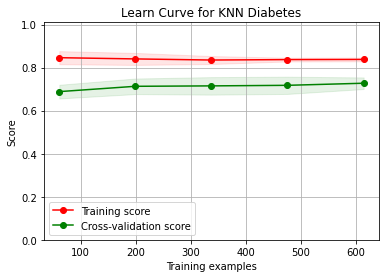

In [64]:
#绘制
knn = KNeighborsClassifier(n_neighbors=2)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(10, 6))
plot_learning_curve(knn, "Learn Curve for KNN Diabetes", 
                    X, Y, ylim=(0.0, 1.01), cv=cv);

从学习曲线看出，训练样本评分低且训练样本与测试样本距离较大，欠拟合

In [67]:
from sklearn.feature_selection import SelectKBest

x_new = SelectKBest(k=2).fit_transform(X,Y)
x_new[0:5]

array([[148. ,  33.6],
       [ 85. ,  26.6],
       [183. ,  23.3],
       [ 89. ,  28.1],
       [137. ,  43.1]])

####对照前面的特征能看出选出来的特征分别是
·GLucose
·BMI

In [93]:
#如果只使用这两个特征，3种不同k-近邻算法哪个更高呢？

results = []
for name,model in models:
    kfold = KFold(n_splits = 10)
    cv_result = cross_val_score(model,x_new,Y,cv = kfold)
    results.append((name,cv_result))
for i in range(len(results)):
    print("name:{} ; cross_val_score {}".format(results[i][0],results[i][1].mean()))

name:KNN ; cross_val_score 0.725205058099795
name:KNN with weights ; cross_val_score 0.6900375939849623
name:Radius Neighbors ; cross_val_score 0.6510252904989747


####说明
·从输出看还是普通的k-均值模型准确性较高
·选出的2个特征很好的训练了模型，SelectKbest选择特征准确

###利用选择出的特征绘制图形看看为什么k-近邻算法没有很好拟合数据

<AxesSubplot:xlabel='Glucose', ylabel='BMI'>

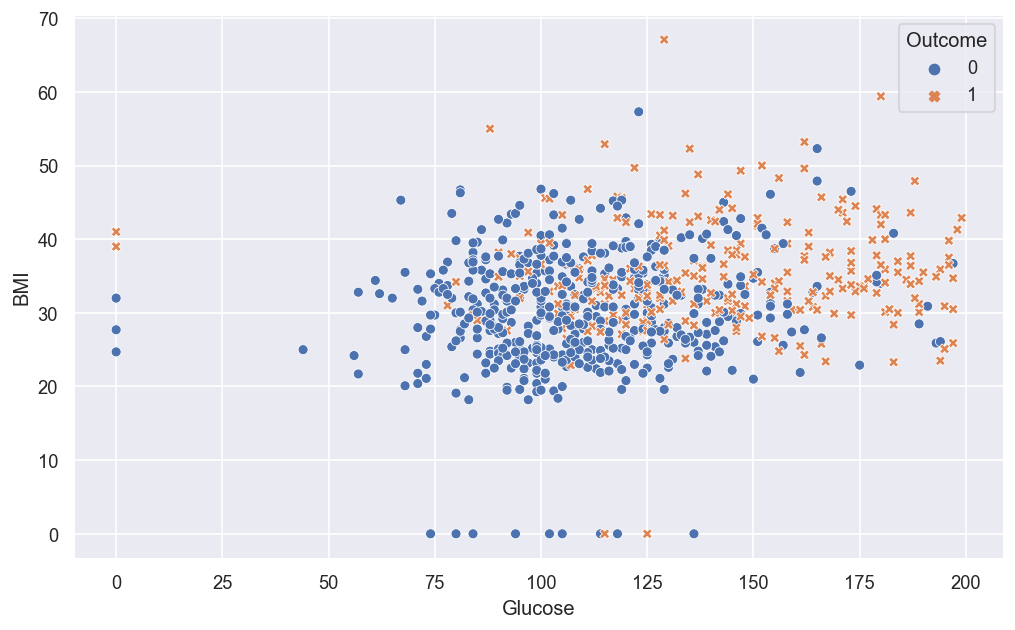

In [100]:
import seaborn as sns 
sns.set()

plt.figure(figsize=(10,6),dpi = 120)
sns.scatterplot(x='Glucose',y='BMI',hue='Outcome' ,style='Outcome',data=data)

   从图中可以看出，在中间数据密集区域，阳性样本和阴性样本几乎重叠在一起了，假设现在有一个待测的样本在中间的密集区域，这很难判断它的阳性邻居多还是阴性邻居多。所以直观的看到k-均值算法在这个糖尿病的预测上，无法达到很高的预测准确性